loss
accuracy
val_loss
val_accuracy


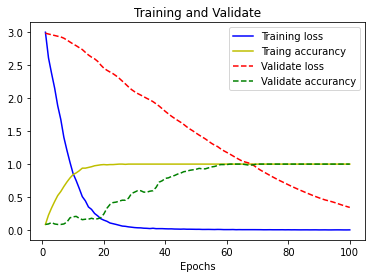

7/7 [==============================] - 0s 10ms/step - loss: 0.4111 - accuracy: 0.9712


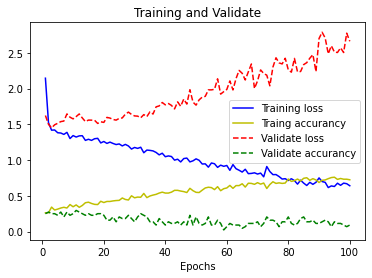

6/6 [==============================] - 0s 12ms/step - loss: 2.3629 - categorical_accuracy: 0.1862


<Figure size 432x288 with 0 Axes>

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pathlib
from PIL import Image

data_path = pathlib.Path('./faces_4/')
all_images_path = list(data_path.glob('*/*'))

all_images_paths = [str(path) for path in all_images_path]

# print(all_images_paths[:10])

len(all_images_paths)


def path2user(path):
    path_list = path.split('/')
    return path_list[1]


def path2phiz(path):
    path_list = path.split('_')
    return path_list[3]


person_labels = list(map(lambda x: path2user(x), all_images_paths))

phiz_labels = list(map(lambda x: path2phiz(x), all_images_paths))

person_labels[:10], phiz_labels[:10]

path_to_index = dict((name.split('/')[2], index) for index, name in enumerate(all_images_paths))
person_to_index = dict((name, index) for index, name in enumerate(list(set(person_labels))))
phiz_to_index = dict((name, index) for index, name in enumerate(list(set(phiz_labels))))

# print(person_to_index, phiz_to_index)

person_targets = [person_to_index[name] for name in person_labels]
phiz_targets = [phiz_to_index[name] for name in phiz_labels]

person_targets[:10], phiz_targets[:10]

person_targets = tf.keras.utils.to_categorical(person_targets)
phiz_targets = tf.keras.utils.to_categorical(phiz_targets)

person_targets[:5], phiz_targets[:5]


def file_to_ids(file):
    cur_path = pathlib.Path(file)
    cur_list = cur_path.open()
    cur_ids = [path_to_index[name.split('/')[-1].split('\n')[0]] for name in cur_list]
    return cur_ids


train_ids = file_to_ids('all_train.list')
val_ids = file_to_ids('all_test1.list')
test_ids = file_to_ids('all_test2.list')

train_ids[:10], val_ids[:10], test_ids[:10]


def get_image(x):
    image = Image.open(all_images_paths[x])
    image = np.array(image)
    image = np.stack([image], axis=-1).astype('float32') / 255.0
    return image


#人脸识别分类

x_train = np.stack(list(map(lambda x: get_image(x), train_ids)), axis=0)
y_train = np.stack(list(map(lambda x: np.array(person_targets[x]), train_ids)), axis=0)
x_val = np.stack(list(map(lambda x: get_image(x), val_ids)), axis=0)
y_val = np.stack(list(map(lambda x: np.array(person_targets[x]), val_ids)), axis=0)
x_test = np.stack(list(map(lambda x: get_image(x), test_ids)), axis=0)
y_test = np.stack(list(map(lambda x: np.array(person_targets[x]), test_ids)), axis=0)

model_input = tf.keras.layers.Input(x_train.shape[1:], dtype=tf.float32)
conv1 = tf.keras.layers.Conv2D(activation='relu', filters=64, kernel_size=(5, 5), padding='valid')(model_input)
pool1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv1)
batch1 = tf.keras.layers.BatchNormalization()(pool1)
conv2 = tf.keras.layers.Conv2D(activation='relu', filters=64, kernel_size=(5, 5), padding='valid')(pool1)
pool2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv2)
batch2 = tf.keras.layers.BatchNormalization()(pool2)
drop = tf.keras.layers.Dropout(0.5)(batch2)
flat = tf.keras.layers.Flatten()(drop)
dense1 = tf.keras.layers.Dense(120, activation='tanh')(flat)
dense2 = tf.keras.layers.Dense(84, activation='relu')(dense1)
model_output = tf.keras.layers.Dense(y_train.shape[1], activation='softmax')(dense2)
keras_model = tf.keras.Model(inputs=model_input, outputs=model_output)

keras_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 128
epochs = 100

hist = keras_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0,
                       validation_data=(x_val, y_val))

history_dict = hist.history

loss_values = history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training loss')
acc = history_dict['accuracy']
plt.plot(epochs, acc, 'y', label='Traing accurancy')
loss_values = history_dict['val_loss']
plt.plot(epochs, loss_values, 'r--', label='Validate loss')
acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'g--', label='Validate accurancy')
plt.title('Training and Validate')
plt.xlabel('Epochs')
plt.legend()
plt.show()
plt.clf()

ans = keras_model.evaluate(x_test, y_test)

#表情识别分类

y_train2 = np.stack(list(map(lambda x: np.array(phiz_targets[x]), train_ids)), axis=0)
y_val2 = np.stack(list(map(lambda x: np.array(phiz_targets[x]), val_ids)), axis=0)
y_test2 = np.stack(list(map(lambda x: np.array(phiz_targets[x]), test_ids)), axis=0)

x_all_data = np.concatenate([x_train, x_val, x_test], axis=0)
y_all_data = np.concatenate([y_train2, y_val2, y_test2], axis=0)

rs = np.random.RandomState(10)
shuffled = list(range(len(x_all_data)))
rs.shuffle(shuffled)
train_size = int(len(shuffled) * 0.7)
x_train = x_all_data[shuffled[:train_size]]
y_train2 = y_all_data[shuffled[:train_size]]
x_test = x_all_data[shuffled[train_size:]]
y_test2 = y_all_data[shuffled[train_size:]]

model_output2 = tf.keras.layers.Dense(y_train2.shape[1], activation='softmax')(dense2)
keras_model2 = tf.keras.Model(inputs=model_input, outputs=model_output2)

keras_model2.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.RMSprop(),
                     metrics=[tf.keras.metrics.categorical_accuracy])

batch_size = 128
epochs = 100

hist = keras_model2.fit(x_train, y_train2, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

history_dict = hist.history
loss_values = history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training loss')
acc = history_dict['categorical_accuracy']
plt.plot(epochs, acc, 'y', label='Traing accurancy')
loss_values = history_dict['val_loss']
plt.plot(epochs, loss_values, 'r--', label='Validate loss')
acc = history_dict['val_categorical_accuracy']
plt.plot(epochs, acc, 'g--', label='Validate accurancy')
plt.title('Training and Validate')
plt.xlabel('Epochs')
plt.legend()
plt.show()
plt.clf()

ans = keras_model2.evaluate(x_test, y_test2)